# Imputation techniques

Missing data is problematic data.
Some machine learning algorithms might not mind `NaN` values, but others won't just complain, but refuse to work altogether.
If we have missing data, then the easier option—removing the missing data—restricts us to using only machine learning algorithms that handle it adequately.
But generally, we want to experiment with different approaches to pick the best.
In these cases, the second option is preferable: we handle the missing data.

pandas and scikit-learn help us find replacements for missing data.
We load these libraries next.

In [1]:
import matplotlib.pyplot as plt
import math
import os
import pandas as pd
import re

We also load the Titanic dataset.
Evn in the first 5 rows, we can see that there is missing data in the `Cabin` column.

In [2]:
df = pd.read_csv('data/titanic-train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Using the `info` method on the DataFrame also shows us that there are missing values in other columns.
For example, only 714 out of 891 rows have `Age` data.
Should we remove the `Age` column, or every passenger without an `Age`?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


If you want to impute a missing value using simple statistical methods, like the mean, median or mode, you can use pandas.
The next code cell fills the `Age` column's missing values with the mean using the `fillna` method.
As you can see when we `describe` the column, the `count` is 891, not 714: that means there are no missing values.

In [4]:
_df = df.copy() # copy the original dataframe
_df.Age = _df.Age.fillna(_df.Age.mean()) # fill the missing values in the `Age` column with the mean
_df.Age.describe() # summarize the `Age` column

count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

You can also achieve the same thing using scikit-learn's imputers.
The imputers are all in the `impute` module (`scikit.impute`).
As usual, there are three steps:

1. Import the imputation module
2. Create the imputer
3. Fit the imputer over the columns and transform (fill in) the missing values

The [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) is... a simple imputer.
When creating the `SimpleImputer`, you can choose a strategy, or how to fill in the missing values, from among the following options:

- `mean`: fill missing values with the average
- `median`: fill missing values with the median
- `most_frequent`: fill missing values with the mode
- `constant`: fill missing values with a constant value

If you choose `constant`, you also need to pass an argument for the `fill_value` parameter (for example, `fill_value=10`).

In [5]:
# step 1: import the imputation module
from sklearn import impute

# step 2: create the imputer
imputer = impute.SimpleImputer(strategy='mean') # we could also choose 'median', 'most_frequent' or 'constant'

# step 3: fill in the missing values
_df = df.copy() # copy the original dataframe
_df[[ 'Age' ]] = imputer.fit_transform(_df[[ 'Age' ]]) # fit (to get the mean) and transform the missing values
_df.Age.describe() # summarize the `Age` column

count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

That can work for the `Age`, but it's too simple.
A more sophisticaed approach is by using kNN.
scikit-learn provides the functionality in the [`KNNImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) class, and the process is very similar to before.

The only difference is that now, we are not passing a single column, `Age`, but also other columns.
These extra columns are used to find the nearest neighbor.
If any value in these extra columns is `NaN` (missing), the `KNNImputer` fills it in too.

In [6]:
# step 2: create the imputer
knn_imputer = impute.KNNImputer(n_neighbors=3)

# step 3: fill in the missing values
_df = df.copy() # copy the original dataframe
_df[[ 'Survived', 'Pclass', 'Age', 'Fare' ]] = knn_imputer.fit_transform(_df[[ 'Survived', 'Pclass', 'Age', 'Fare' ]]) # fit and transform the missing values
_df.Age.describe() # summarize the `Age` column

count    891.000000
mean      30.136899
std       13.998037
min        0.420000
25%       21.000000
50%       29.000000
75%       38.500000
max       80.000000
Name: Age, dtype: float64

You can impute values in other ways too.
Unfortunately, scikit-learn does not have a linear regression imputer, but there's no reason we cannot create it ourselves.

First, we need to train a linear regression model, shown next.
This model simply uses `Survived`, `Pclass` and `Fare` to predict the `Age`.

In [7]:
# step 1: import the linear regression algorithm
from sklearn.linear_model import LinearRegression

# step 2: create the model
linear_regression = LinearRegression()

# step 3: fit the model
_df = df.copy() # create a copy of the dataframe

# # we cannot train the model if the label (Age) has missing values, so we drop those rows **temporarily**
_df = _df.dropna(subset=[ 'Age' ])
# we'll use the `Survived` label, and the passenger class and fare to predict age
X = _df[[ 'Survived', 'Pclass', 'Fare' ]]
y = _df.Age # we want to predict (impute) the Age
linear_regression = linear_regression.fit(X, y) # finally, we fit (train) the linear regression model

Now we have a linear regression model that we can use to predict missing age values.
Similarly to before, we'll use the `Survived`, `Pclass` and `Fare` to predict the `Age`.
To fill in missing `Age` values, we follow three steps:

1. We shouldn't overwrite existing `Age` values.
   Therefore we use the `isna` method, which gives us, for each row, whether the `Age` is missing or not.
2. For each row where the `Age` is missing, use the linear regression model to make a prediction.
3. Fill the rows where the `Age` is missing with the linear regression model's predictions.

In [8]:
_df = df.copy() # create another copy of the dataframe
# again, we use the same columns that we used for training to make predictions
X = _df[[ 'Survived', 'Pclass', 'Fare' ]]

# step 1: check which rows have missing `Age`
where_nan = df.Age.isna()

# step 2: predict the `Age`, but only for rows where it's missing!
predictions = linear_regression.predict(X.loc[where_nan])

# step 3: fill the rows where the `Age` is missing with the prediced values
_df.loc[where_nan, 'Age'] = predictions
_df.Age.describe()

count    891.000000
mean      29.286540
std       13.361987
min        0.420000
25%       21.000000
50%       26.514635
75%       36.000000
max       80.000000
Name: Age, dtype: float64

## Outlier detection

Outliers can be misleading, especially in some distance-based algorithms, like k-Means.
The next visualization shows how most `Fare` values are lower than the 200 mark, but a few are over 500.
What gives?

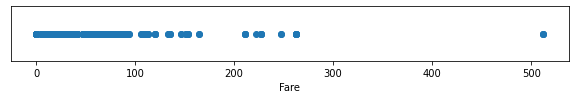

In [9]:
# draw a visualization showing the distribution of fare
plt.figure(figsize=(10, 1)) # create a figure with a custom size
plt.scatter(df.Fare, [ 0 ] * len(df.Fare)) # draw a scatter plot with age on the x-axis and fare on the y-axis
plt.yticks([ ]) # remove y-ticks
plt.xlabel('Fare') # set the x-label to say 'Fare'
plt.show() # show the plot

pandas' [describe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function can help us gauge the range of values of a column.
The next cell shows us how the fare has a mean value of 32 and a relatively large standard deviation of 49.

More importantly, look at the percentiles:

- 25% of fares are between 0 and 7.9
- 25% of fares are between 7.9 and 14.5
- 25% of fares are between 14.5 and 31
- 25% of fares are between 31 and 512

The last 4-quantile is _huge_, partially because of the outliers higher than 500.

In [10]:
df.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

If we're in doubt whether the highest values are mistakes, then we can identify these outliers.
Once we identify outliers, we can remove them or replace them with a different value using imputation.

A simple way of identifying outliers in `Fare` is by using percentiles.
Confusingly, `pandas` calls percentiles 'quantiles', and we can extract them using the [quantile](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html) function.
In short, the quantile given by 0.9975 means that 99.75% of `Fare` values are below the threshold.

In [11]:
threshold = df.Fare.quantile(0.9975) # get the threshold such that 99.75% of fares are below it

After that, it's a matter of filtering our dataset if we want to remove outliers.
The next cell selects only passengers whose `Fare` is below the threshold.
If we're happy, we can store the DataFrame to a variable.

In [12]:
df[ df.Fare <= threshold ] # select only passengers whose Fare is below the threshold

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


To get an idea of what's happening, the next cell visualizes differnet percentiles.
As you can see, the decision on where to place the threshold depends on how conservative we want to be (how sure are we that we don't have outliers?) and how much data we have (do we afford to remove 5% of data?).

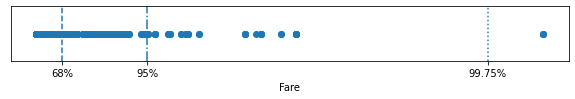

In [13]:
# draw a visualization showing the distribution of fare
plt.figure(figsize=(10, 1)) # create a figure with a custom size
plt.scatter(df.Fare, [ 0 ] * len(df.Fare)) # draw a scatter plot with just fare on the x-axis (all points have the same y-coordinate)
plt.axvline(df.Fare.quantile(0.68), linestyle='--') # draw the 68% percentile
plt.axvline(df.Fare.quantile(0.95), linestyle='-.') # draw the 95% percentile
plt.axvline(df.Fare.quantile(0.9975), linestyle=':') # draw the 99.75% percentile

# add labels next to the thresholds
plt.xticks([ df.Fare.quantile(q) for q in [ 0.68, 0.95, 0.9975 ] ],
           [ '68%', '95%', '99.75%' ])
plt.xlabel('Fare') # set the x-label to say 'Fare'
plt.yticks([ ]) # remove the vertical ticks (since all points have the same y-coordinate)
plt.show() # show the plot

Alternatively, we can use the mean and the standard deviation.
Again, pandas comes to the rescue with its aggregation functions: `mean` and `std`.

In [14]:
mean = df.Fare.mean() # calculate the mean value of the Fare
stdev = df.Fare.std() # calculate the standard deviation of the Fare

As we did before, we can filter the DataFrame by looking for passengers with a lower `Fare` than the threshold.
If we're happy with the results, we can store the rows in a variable.

In [15]:
df[ df.Fare <= mean + stdev * 3 ] # select only passengers whose Fare is below the threshold

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


As you can see above, we kept 871 rows.
So this operation removed 20 rows out of 891, not 3, like the percentiles.
The next visualization shows exactly why: the third standard deviation is relatively low.

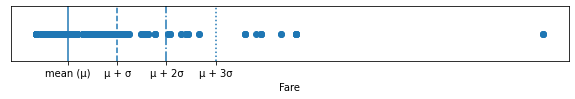

In [16]:
# draw a visualization showing the distribution of fare
plt.figure(figsize=(10, 1)) # create a figure with a custom size
plt.scatter(df.Fare, [ 0 ] * len(df.Fare)) # draw a scatter plot with just fare on the x-axis (all points have the same y-coordinate)
plt.axvline(mean) # draw a line where the mean is
plt.axvline(mean + stdev, linestyle='--') # draw a line one standard deviation from the mean
plt.axvline(mean + stdev * 2, linestyle='-.') # draw a line two standard deviations from the mean
plt.axvline(mean + stdev * 3, linestyle=':') # draw a line three standard deviations from the mean

# add labels next to the thresholds
plt.xticks([ mean + stdev * i for i in range(4) ],
           [ 'mean (μ)', 'μ + σ', 'μ + 2σ', 'μ + 3σ' ])
plt.xlabel('Fare') # set the x-label to say 'Fare'
plt.yticks([ ]) # remove the vertical ticks (since all points have the same y-coordinate)
plt.show() # show the plot

Which one is better?
That depends on your application, how aggressive you want to be when removing outliers, and how aggressive you _afford_ to be.

## Engineering new features

We have focused a lot on removing features, but what about creating our own?
If we understand the data sufficiently, we can derive some additional data that makes sense, which can help machine learning algorithms make better predictions.

Sometimes, engineering new features might even be necessary, and not just desirable.
For example, say you receive a simplified Titanic dataset.
You still need to predict whether a passenger survived, but you only have one column.

And there's a catch.
It's the most useless, noisy column you can imagine: the passenger's name.

In [17]:
_df = df.loc[:, [ 'Name', 'Survived' ] ]
_df.head()

,Name,Survived
0,"Braund, Mr. Owen Harris",0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1
2,"Heikkinen, Miss. Laina",1
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1
4,"Allen, Mr. William Henry",0


That's not a lost cause though, is it?
There is one important clue in the name—can you spot it?

It's the title.
Every person has a title, which gives us precious information.
Maybe a priest was more likely to sacrifice himself for the good of others!

In the next cell, we extract the titles (using data from [triangleinequality](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)).

In [18]:
titles = [ 'Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
           'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
           'Don', 'Jonkheer' ]
title = re.compile(f"{ '|'.join(titles) }")
titles = _df.Name.map(lambda passenger: title.findall(passenger)[0])
_df['Title'] = titles
_df.head()

,Name,Survived,Title
0,"Braund, Mr. Owen Harris",0,Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,Mrs
2,"Heikkinen, Miss. Laina",1,Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,Mrs
4,"Allen, Mr. William Henry",0,Mr


Have you ever called a woman _Mr_?
I think not.
The titles can give us another valuable piece of information: gender.
With the gender, we can make better predictions because we know that women were more likely to survive than men.

In [19]:
sexes = { 'Mrs': 'female', 'Mr': 'male', 'Master': 'male', 'Miss': 'female', 'Major': 'male', 'Rev': 'male',
          'Dr': 'unknown', 'Ms': 'female', 'Mlle': 'female', 'Col': 'male', 'Capt': 'male',
          'Mme': 'female', 'Countess': 'female', 'Don': 'male', 'Jonkheer': 'unknown' }
sexes = _df.Title.map(lambda title: sexes[title])
_df['Sex'] = sexes
_df.head()

,Name,Survived,Title,Sex
0,"Braund, Mr. Owen Harris",0,Mr,male
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,Mrs,female
2,"Heikkinen, Miss. Laina",1,Miss,female
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,Mrs,female
4,"Allen, Mr. William Henry",0,Mr,male


And there's even more we can do!
Back then, the title _Mrs_ was used to address married women and _Miss_ was used to address unmarried women.
And it's unthinkable that priests (whose title is _Rev_), military persons (_Major_, _Col_ and _Capt_) or doctors (_Dr_) would be younger than 18.
Based on this information, can we guess the ages, such as _child_, _adult_ or _unknown_?

In [20]:
ages = { 'Mrs': 'unknown', 'Mr': 'unknown', 'Master': 'unknown', 'Miss': 'young', 'Major': 'adult', 'Rev': 'adult',
         'Dr': 'adult', 'Ms': 'unknown', 'Mlle': 'unknown', 'Col': 'adult', 'Capt': 'adult',
         'Mme': 'unknown', 'Countess': 'unknown', 'Don': 'unknown', 'Jonkheer': 'unknown' }
ages = _df.Title.map(lambda title: ages[title])
_df['Age'] = ages
_df.head()

,Name,Survived,Title,Sex,Age
0,"Braund, Mr. Owen Harris",0,Mr,male,unknown
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,Mrs,female,unknown
2,"Heikkinen, Miss. Laina",1,Miss,female,young
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,Mrs,female,unknown
4,"Allen, Mr. William Henry",0,Mr,male,unknown


## Next steps

The best way to understand what you can or should do with missing data, or what you can and should do with outliers, is by experimenting.
So experiment, and make sure to understand your data.

That concludes the basiscs of feature engineering.
There is just one remaining stop on the feature engineering trip: dimensionality reduction, up next.